<h1>A3I Project - Choreography Planning by Decoupling A* Deterministic Search and Heuristic Computation</h1>
<h4 style="text-align: center">Authors: Lorenzo Balzani, Davide Bombardi</h4>
<p style="text-align: center">
    <a href="mailto:lorenzo.balzani@studio.unibo.it">lorenzo.balzani@studio.unibo.it</a> -
    <a href="mailto:davide.bombardi@studio.unibo.it">davide.bombardi@studio.unibo.it</a>
</p>


<h2>Abstract</h2>
<div class="abstract">
    <p>To Be Written (TBW)</p>
</div>

## Setup
Perform the following steps to setup the environment for running the code in this notebook:
1. Create a file named `secrets.env` in the root directory of the project and add the following lines:
    ```bash
    OPENAI_API_KEY=<your_openai_api_key>
    OPENAI_API_URL=https://api.openai.com
    ```
2. Setup the environment by launching the script `./setup_env.sh` in the terminal.
3. After activate it with `conda activate a3i`.
4. For installing the ipython kernel, please run `python -m ipykernel install --user --name=a3i`.

In [ ]:
!pip install load_dotenv
!pip install langchain_openai
!pip install loguru

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.8 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.19
    Uninstalling langchain-core-0.3.19:
      Successfully uninstalled langchain-core-0.3.19
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.6 MB/s eta 0:00:00


In [4]:
%%capture
from dotenv import load_dotenv
import networkx as nx
from itertools import permutations
from itertools import product
import matplotlib.pyplot as plt
from langchain_openai import AzureChatOpenAI
from langchain_core.prompts import PromptTemplate
import random
from loguru import logger
import re
import heapq

load_dotenv("secrets.env")
seed = 42
random.seed(seed)

In [103]:
gpt_4o = AzureChatOpenAI(
    deployment_name="gpt-4o",
    temperature=0,
    verbose=True,
)

gpt_4o_mini = AzureChatOpenAI(
    deployment_name="gpt-4o-mini",
    temperature=0,
    verbose=True,
)

## Position Graph Creation

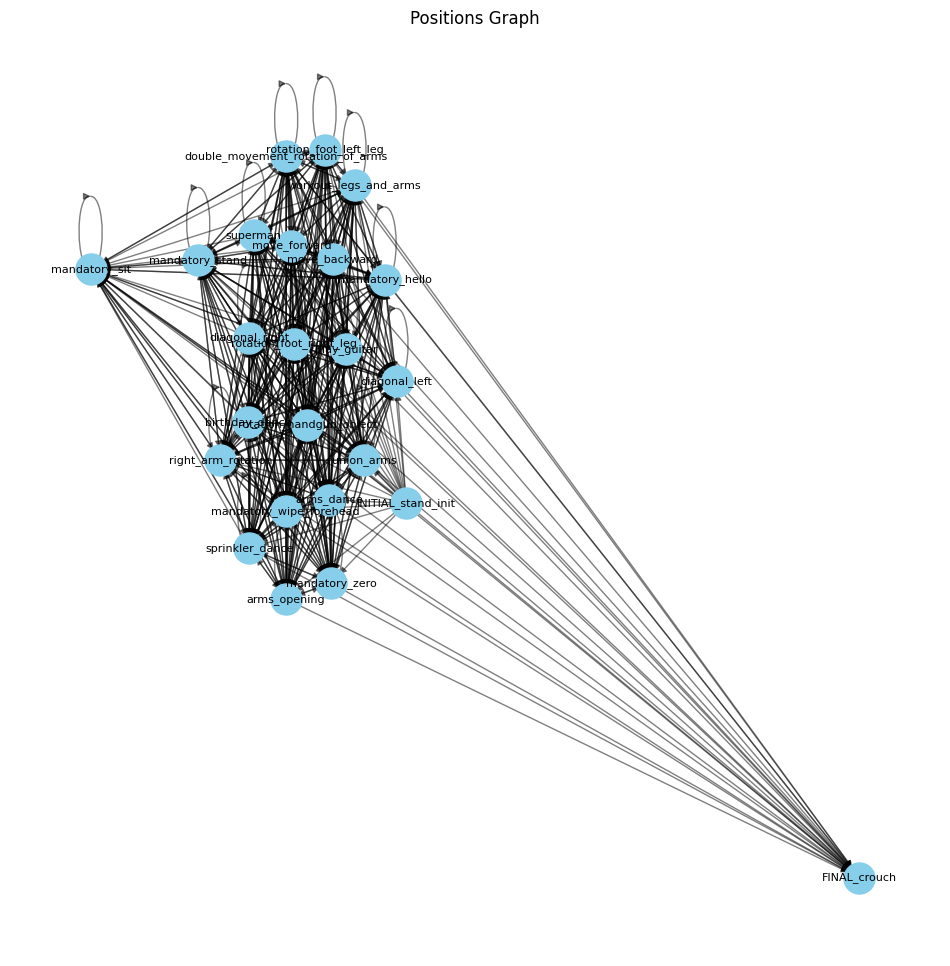

In [5]:
initial_state = 'INITIAL_stand_init'
final_state = 'FINAL_crouch'

# Define the list of nodes
nodes = {initial_state, 'rotation_handgun_object', 'right_arm_rotation', 'double_movement_rotation_of_arms',
         'arms_opening', 'union_arms', 'move_forward', 'move_backward', 'diagonal_left', 'diagonal_right',
         'rotation_foot_left_leg', 'rotation_foot_right_leg', 'play_guitar', 'arms_dance', 'birthday_dance',
         'sprinkler_dance', 'workout_legs_and_arms', 'superman', 'mandatory_sit', 'mandatory_wipe_forehead',
         'mandatory_hello', 'mandatory_stand', 'mandatory_zero', final_state}

# Define the exception nodes for which there are incompatible transitions
exception_nodes = {"mandatory_sit": {'diagonal_right', 'diagonal_left', 'rotation_foot_right_leg', 'rotation_foot_left_leg',
                                     final_state, 'move_backward', 'move_forward', 'play_guitar', 'arms_dance', 'birthday_dance',
                                     'sprinkler_dance', 'workout_legs_and_arms', 'superman'}
}


# Initialize the directed graph, since there are incompatible transitions between some nodes
G = nx.DiGraph()
G.add_nodes_from(nodes)

# Add edges between all pairs of nodes except the specified exceptions
for u, v in product(nodes, repeat=2):
    if u == final_state: # Skip adding edges from 'FINAL_crouch' to other nodes, since it is the final node
        continue
    if v == initial_state: # Skip adding edges to 'INITIAL_stand_init', since it is the initial node
        continue
    if u in exception_nodes and v in exception_nodes[u]: # Skip adding edges if the pair is in the exception list
        continue
    G.add_edge(u, v, weight=1)  # Add an edge with a cost of 1

# Visualize the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15)
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')

plt.axis('off')
plt.title('Positions Graph')
plt.show()

## Graph Statistics

In [7]:
# 1. Number of nodes
num_nodes = G.number_of_nodes()
print(f"1. Number of nodes: {num_nodes}")

# 2. Number of edges
num_edges = G.number_of_edges()
print(f"2. Number of edges: {num_edges}")

# 3. Average in-degree and out-degree
in_degrees = G.in_degree()
out_degrees = G.out_degree()
avg_in_degree = sum(dict(in_degrees).values()) / num_nodes
avg_out_degree = sum(dict(out_degrees).values()) / num_nodes
print(f"3. Average in-degree: {avg_in_degree:.2f}\t--\tAverage out-degree: {avg_out_degree:.2f}")

# 4. Density of the graph
density = nx.density(G)
print(f"4. Graph density: {density:.4f}")

# 5. Is the graph strongly connected?
is_strongly_connected = nx.is_strongly_connected(G)
print(f"5. Is the graph strongly connected? {is_strongly_connected}")

# 6. Number of strongly connected components
num_scc = nx.number_strongly_connected_components(G)
print(f"6. Number of strongly connected components: {num_scc}")

# 7. Average clustering coefficient
# For DiGraph, we use the directed version of clustering coefficient
avg_clustering = nx.average_clustering(G)
print(f"7. Average clustering coefficient: {avg_clustering:.4f}")

# 8. Top 3 nodes by PageRank
pagerank = nx.pagerank(G)
top_3_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:3]
print("8. Top 3 nodes by PageRank:")
for node, pr in top_3_pagerank:
    print(f"  {node}: {pr:.4f}")

# 9. In-degree and out-degree of 'mandatory_sit'
in_degree_mandatory_sit = G.in_degree('mandatory_sit')
out_degree_mandatory_sit = G.out_degree('mandatory_sit')
print(f"9. 'mandatory_sit' in-degree: {in_degree_mandatory_sit}\t--\tout-degree: {out_degree_mandatory_sit}")

# 10. Average shortest path length (if the graph is strongly connected)
if is_strongly_connected:
    avg_shortest_path_length = nx.average_shortest_path_length(G)
    print(f"10. Average shortest path length: {avg_shortest_path_length:.4f}")
else:
    print("10. Graph is not strongly connected; average shortest path length not defined.")

# 11. Number of nodes with zero in-degree (sources)
zero_in_degree = [n for n, d in G.in_degree() if d == 0]
print(f"11. Number of nodes with zero in-degree (sources): {len(zero_in_degree)}")

# 12. Number of nodes with zero out-degree (sinks)
zero_out_degree = [n for n, d in G.out_degree() if d == 0]
print(f"12. Number of nodes with zero out-degree (sinks): {len(zero_out_degree)}")

# 13. Diameter of the graph (if strongly connected)
if is_strongly_connected:
    diameter = nx.diameter(G)
    print(f"13. Diameter of the graph: {diameter}")
else:
    print("13. Graph is not strongly connected; diameter not defined.")

# 14. Eccentricity of the initial state (if strongly connected)
if is_strongly_connected:
    eccentricity = nx.eccentricity(G, initial_state)
    print(f"14. Eccentricity of '{initial_state}': {eccentricity}")
else:
    print("14. Graph is not strongly connected; eccentricity not defined.")

1. Number of nodes: 24
2. Number of edges: 516
3. Average in-degree: 21.50	--	Average out-degree: 21.50
4. Graph density: 0.9348
5. Is the graph strongly connected? False
6. Number of strongly connected components: 3
7. Average clustering coefficient: 0.9365
8. Top 3 nodes by PageRank:
  rotation_handgun_object: 0.0453
  mandatory_zero: 0.0453
  mandatory_stand: 0.0453
9. 'mandatory_sit' in-degree: 23	--	out-degree: 10
10. Graph is not strongly connected; average shortest path length not defined.
11. Number of nodes with zero in-degree (sources): 1
12. Number of nodes with zero out-degree (sinks): 1
13. Graph is not strongly connected; diameter not defined.
14. Graph is not strongly connected; eccentricity not defined.


## Graph Waypoints definition

In [102]:
# Define a prompt template for getting waypoints
waypoint_prompt = PromptTemplate(
    input_variables=['initial_state', 'final_state', 'positions'],
    template="""
    Given the initial state {initial_state} and the final state {final_state}, output a **strictly comma-separated list** of positions from the available ones that create a very cool, elegant and creative movement sequence. Include initial and final state. Do not include any other text in the output, and format the list exactly as: `position1, position2, position3`.

    # POSITIONS
    {positions}
    """
)

# Create an LLMChain for waypoints
waypoint_chain = waypoint_prompt | gpt_4o

# Define the available positions as the union of all the nodes except the initial and final states
available_positions = list(nodes - {initial_state, final_state})
random.shuffle(available_positions)

# Run the chain
result = waypoint_chain.invoke({"initial_state": initial_state, "final_state": final_state, "positions": available_positions})

# Extract the comma-separated list using regex
waypoints = re.findall(r'\b\w+(?:, \w+)*\b', result.content)
print(f"Waypoints sequence: {waypoints}")

Waypoints sequence: ['INITIAL_stand_init', 'rotation_foot_right_leg', 'arms_dance', 'superman', 'play_guitar', 'FINAL_crouch']


## A* Search Algorithm between waypoints
### Herustic definition
Should receive:
1. Current state, i.e. made of the sequence of positions already visited + the current position
2. The next waypoint to reach
3. max_coolness_score

Evaluate the current state with respect to the goal of reaching the next waypoint in the coolest way possible.

In [105]:
heuristic_prompt = PromptTemplate(
    input_variables=['dance_sequence', 'max_coolness_score'],
    template="""
    You are an expert choreographer evaluating a dance sequence represented as a path of moves. Each node in the sequence is a dance move or position. The overall sequence is assigned a "coolness" score ranging from 0 to {max_coolness_score}, where higher scores indicate more impressive, cohesive, and visually stunning choreography.

    **Task:**
    Provide two numerical scores:
    1. The total coolness score of the given dance sequence so far, based on the transitions between its moves. This score should be determined in a detailed, analytical, and objective manner, considering creativity, flow, audience appeal, and overall visual impression.
    2. A projected maximum possible coolness score achievable if, from the end of the current sequence, you select the very best possible moves and transitions for all remaining steps.

    **Important Guidelines:**
    - **Evaluation Criteria:** Rate transitions consistently and fairly. Similar transitions should yield similar scores.
    - **Heuristic Consideration:** The second score should serve as a heuristic estimate for an A* search, guiding the algorithm with a reasonably accurate but not overly optimistic upper bound.
    - **Output Structure**: Provide ONLY the two scores in the following format: `coolness_score1,coolness_score2`. Nothing else.

    **Dance Sequence:** {dance_sequence}
    """
)

In [124]:
heuristic_cache = {}
gpt_4o_mini_costs = {"prompt": 0.14311/1e6, "completion": 0.5725/1e6}

def estimate_coolness_to_goal_llm(dance_sequence, max_coolness_score=100):
    """
    Estimate the coolness of transitioning from the current node to the goal node using the LLM.

    Parameters:
    - dance_sequence (List[str]): The sequence of dance moves leading up to the current node.
    - max_coolness_score (float, Optional): The maximum possible coolness score. Defaults to 100.

    Returns:
    - coolness_score (float): The estimated coolness score for transitioning to the goal node.
    - coolness_estimation (float): The estimated maximum possible coolness score for the entire sequence.
    - total_cost (float): The total cost of invoking the LLM.
    """

    dance_sequence = tuple(dance_sequence)

    # Check if the coolness value is already computed and cached
    if dance_sequence in heuristic_cache:
        return *heuristic_cache[dance_sequence], 0

    # Prepare the inputs for the LLM prompt
    prompt_inputs = {
        'dance_sequence': str(list(dance_sequence)),
        'max_coolness_score': max_coolness_score
    }

    # Run the chain, extract and process the response
    try:
        # Call the LLM to get the coolness score
        response = (heuristic_prompt | gpt_4o_mini).invoke(prompt_inputs)
        cost = response.response_metadata["token_usage"]
        total_cost = cost["prompt_tokens"] * gpt_4o_mini_costs["prompt"] + cost["completion_tokens"] * gpt_4o_mini_costs["completion"]

        current_coolness, coolness_estimation = response.content.strip().split(",")

        coolness_score = max(0, int(current_coolness))
        coolness_estimation = max(0, int(coolness_estimation))

        coolness_score = min(coolness_score, max_coolness_score)
        coolness_estimation = min(coolness_estimation, max_coolness_score)

        # Store the coolness score in the cache
        heuristic_cache[dance_sequence] = (coolness_score, coolness_estimation)

        return *heuristic_cache[dance_sequence], total_cost
    except ValueError as e:
        raise ValueError(f"Invalid response from the LLM: {e}")

## Definizione delle funzioni di A*
Se ho capito bene, normalmente 𝓰(P)+𝒽(P) da un valore che rappresenta una stima del punteggio della miglior soluzione ottenibile partendo da P. In particolare 𝓰(P) è il punteggio accumulato da P fino a questo punto, mentre 𝒽(P) è una stima del punteggio migliore ottenibile partendo da P.
Nel nostro caso il punteggio che vogliamo massimizzare è la coolness, che però può essere calcolata solo da un llm. Di conseguenza sia 𝓰(P) che 𝒽(P) vanno trovate usando un llm (???)

### 1. Coolness 𝓰 di un percorso:
Si potrebbe chiedere al llm quanto è buona la soluzione P con un punteggio cool(P) ∈ ]0,100[. Per indirizzare verso il completamento degli obbiettivi, si potrebbe tener conto degli obiettivi raggiunti.

La funzione 𝓰 potrebbe essere 𝓰(P):

𝓰(P) = -cool(P)⋅(#obiettivi raggiunti / #Obiettivi totali)

Così risulterà con un punteggio più alto (col meno = basso dato che A* cerca di ridurre il cossto) il percorso più cool fino a quel momento e a parità di coolness quello con più obiettivi raggiunti

### 2. Euristica 𝒽 di un percorso:
Nel normale algoritmo A*, 𝓰(P)+𝒽(P) da una stima del costo del miglior percorso che si può creare preseguendo con P. Nel nostro caso quindi si potrebbe chiedere all'llm che punteggio potrebbe ottenere una coreografia che parte da P e poi prosegue nel modo ottimale? Forse è una richiesta un po' troppo astratta. Se questo punteggio è cool_estimation(P), avremo che

𝒽(P) = - cool_estimation(P) + cool(P)

N.B. cool(P) e cool_estimation(P) potrebbero essere chieste anche insieme all'llm con un unico prompt.

### 3. Vicinanza al prossimo target:
Deve spingere A* a scegliere la strada che porta al target successivo:
𝓽(P) = lunghezza per arrivare al target

## Priorità di un percorso:
Non so se ha senso valutare dei pesi. Forse no. Nel caso sarebbe:

Pr(P)  =  α ⋅ 𝓰(P)  +  β ⋅ 𝒽(P)  +  γ ⋅ 𝓽(P)

In [89]:
def g_function(sequence, mandatory_positions, intermediate_positions, n_intermediate_positions, mandatory_check, intermediate_check, intermediate_count, cool):
    move = sequence[-1]
    if move in mandatory_positions and not move in mandatory_check:
        mandatory_check.append(move)
    elif move in intermediate_positions and not move in intermediate_check:
        intermediate_count += 1
        intermediate_check.append(move)
    achieved_goals = (len(mandatory_positions)-len(mandatory_check)) + (n_intermediate_positions-intermediate_count)
    goals = len(mandatory_positions) + n_intermediate_positions
    return - cool * achieved_goals / goals


def h_function(cool, cool_estimation):
  return - cool_estimation + cool

def t_function(sequence, current_target, shortest_path):
    """Dovrebbe indicare quante mosse mancano a poter aggiungere il target. 0 se si può aggiungere subito dopo.
  Si potrebbe usare nx.shortest_path_length(graph, sequence[-1], current_target)
  Oppure, dato che non dipende da il percorso fatto ma solo da due nodi, si potrebbe calcolare per ogni coppia di nodi con nx.all_pairs_shortest_path_length(graph) A PRIORI e in questa funzione
  si consulta solo la mega matrice/dizionario"""
    return shortest_path[sequence[-1]][current_target]


In [128]:
def LLM_AStar_4Choreography(graph, start, goal, targets, mandatory_positions, intermediate_positions, n_intermediate_postions, g_function, h_function, t_function):
    """
    Arguments:
    ----------
        graph
        start
        goal
        targets
        mandatory_positions
        intermediate_positions
        n_intermediate_positions
        g_function
        h_function
        t_function

    Returns:
    -------
        path
    """
    open_set = []
    total_cost = 0
    total_calls = 0
    heapq.heappush(open_set, (0, [start], 1))  # (estimated coolness of complete path, uncompleted path, index of current target)
    shortest_path = dict(nx.all_pairs_shortest_path_length(graph))

    while open_set:
        _, current_sequence, current_target_index = heapq.heappop(open_set)
        current_target = targets[current_target_index]
        current_node = current_sequence[-1]

        if current_node == goal:
            return current_sequence
        elif current_node == current_target:
            if current_target_index < len(targets) - 1:
                current_target_index += 1
                current_target = targets[current_target_index]

        mandatory_check = []
        intermediate_check = []
        intermediate_count = 0
        for move in current_sequence:
          if move in mandatory_positions and not move in mandatory_check:
            mandatory_check.append(move)
          elif move in intermediate_positions and not move in intermediate_check:
            intermediate_count += 1
            intermediate_check.append(move)
        if len(mandatory_check) == len(mandatory_positions) and intermediate_count == n_intermediate_postions:
          all_goals_achieved = True
        else:
          all_goals_achieved = False

        for move in graph.neighbors(current_node):
            if all_goals_achieved or move != goal:
                new_sequence = current_sequence + [move]

                '''llm'''
                cool, cool_estimation, heuristic_cost = estimate_coolness_to_goal_llm(new_sequence)
                total_cost += heuristic_cost
                total_calls += 1

                estimated_coolness = g_function(new_sequence, mandatory_positions, intermediate_positions, n_intermediate_postions,
                                                mandatory_check, intermediate_check, intermediate_count, cool) + h_function(cool, cool_estimation)
                if move != current_target:
                    estimated_coolness += t_function(new_sequence, current_target, shortest_path)
                heapq.heappush(open_set, (estimated_coolness, new_sequence, current_target_index))
        print(f"Current sequence: {current_sequence}")
        print(f"Current cost: {total_cost:.6f}€ - Total calls: {total_calls}\n")
    return None


In [129]:
mandatory_positions = {'mandatory_sit', 'mandatory_wipe_forehead', 'mandatory_hello', 'mandatory_stand', 'mandatory_zero'}
intermediate_positions = list(nodes - {initial_state, final_state} - mandatory_positions)
n_intermediate_positions = 5

LLM_AStar_4Choreography(graph=G, start=initial_state, goal=final_state, targets=waypoints,
                        mandatory_positions=mandatory_positions, intermediate_positions=intermediate_positions,
                        n_intermediate_postions=n_intermediate_positions, g_function=g_function, h_function=h_function, t_function=t_function)

Current sequence: ['INITIAL_stand_init']
Current cost: 0.000000€ - Total calls: 22

Current sequence: ['INITIAL_stand_init', 'superman']
Current cost: 0.000000€ - Total calls: 44

Current sequence: ['INITIAL_stand_init', 'superman', 'mandatory_zero']
Current cost: 0.000000€ - Total calls: 66

Current sequence: ['INITIAL_stand_init', 'superman', 'rotation_handgun_object']
Current cost: 0.000000€ - Total calls: 88

Current sequence: ['INITIAL_stand_init', 'superman', 'sprinkler_dance']
Current cost: 0.000000€ - Total calls: 110

Current sequence: ['INITIAL_stand_init', 'superman', 'sprinkler_dance', 'sprinkler_dance']
Current cost: 0.000000€ - Total calls: 132

Current sequence: ['INITIAL_stand_init', 'superman', 'sprinkler_dance', 'sprinkler_dance', 'sprinkler_dance']
Current cost: 0.000000€ - Total calls: 154

Current sequence: ['INITIAL_stand_init', 'superman', 'sprinkler_dance', 'sprinkler_dance', 'sprinkler_dance', 'superman']
Current cost: 0.000000€ - Total calls: 176

Current sequ

KeyboardInterrupt: 

In [ ]:
# Check if initial and final states are in the waypoints
if initial_state not in waypoints:
    waypoints = [initial_state] + waypoints
if final_state not in waypoints:
    waypoints.append(final_state)

# A* path planning between waypoints
complete_path = []

for i in range(len(waypoints) - 1): # Iterate over pairs of waypoints
    print(f"\nFinding path between {waypoints[i]} and {waypoints[i + 1]}")
    start = waypoints[i]
    goal = waypoints[i + 1]
    try:
        # Perform A* search with the LLM heuristic
        path_segment = nx.astar_path(G, start, goal, heuristic=heuristic, weight='weight')
        # Exclude the start node to prevent duplication
        path_segment = path_segment[1:] if i > 0 else path_segment
        complete_path.extend(path_segment)
    except nx.NetworkXNoPath:
        print(f"No path found between {start} and {goal}")
        complete_path = None
        break
    print(f"Updated complete path: {complete_path}")


Finding path between INITIAL_stand_init and arms_opening
Coolness percieved from arms_opening to arms_opening: 5.0 (higher is better)
Coolness percieved from move_forward to arms_opening: 7.0 (higher is better)
Coolness percieved from arms_dance to arms_opening: 7.0 (higher is better)
Coolness percieved from mandatory_sit to arms_opening: 7.0 (higher is better)
Coolness percieved from play_guitar to arms_opening: 7.0 (higher is better)
Coolness percieved from double_movement_rotation_of_arms to arms_opening: 7.0 (higher is better)
Coolness percieved from birthday_dance to arms_opening: 7.0 (higher is better)
Coolness percieved from workout_legs_and_arms to arms_opening: 7.0 (higher is better)
Coolness percieved from right_arm_rotation to arms_opening: 7.0 (higher is better)
Coolness percieved from rotation_foot_right_leg to arms_opening: 7.0 (higher is better)
Coolness percieved from mandatory_hello to arms_opening: 7.0 (higher is better)
Coolness percieved from rotation_foot_left_leg

In [ ]:
# Output the complete path
if complete_path:
    print(f"Complete Path:\n{complete_path}")
else:
    print("Failed to find a complete path.")

Complete Path:
['INITIAL_stand_init', 'arms_opening', 'superman', 'rotation_foot_right_leg', 'mandatory_sit', 'double_movement_rotation_of_arms', 'FINAL_crouch']
